This notebook is used to test and debug utility functions before integrating them into ```utils.py```.
Functions are migrated from exploratory notebooks (e.g. ```differential_analyse_Borealis.ipynb```) and refined here.

In [93]:
# Imports required for battery data processing and differential analysis
from pathlib import Path
import re
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy import interpolate
from scipy.integrate import cumulative_trapezoid

In [94]:
# Link key variables to column names, both from the original dataset and for new columns generated during processing.

# Dataset_given
T = 'Test_Time(s)'
I = 'Current(A)'
V = 'Voltage(V)'
Qc = 'Charge_Capacity(Ah)'
Qd = 'Discharge_Capacity(Ah)'
Ec = 'Charge_Energy(Wh)'
Ed = 'Discharge_Energy(Wh)'
P = 'Power(W)'
dqdv_raw = 'dQ/dV(Ah/V)'
dvdq_raw = 'dV/dQ(V/Ah)'

# Uniform grid
uniq = "Uniform_Q_grid (Ah)"
univ = "Uniform_V_grid (V)"
unie = "Uniform_E_grid (Wh)"
unit = "Uniform_t_grid (h)"

# Interpolated
v_uniq = 'V_from_uniform_Q (V)'
q_univ = 'Q_from_uniform_V (Ah)'
v_unit = 'V_from_uniform_t (V)'
p_unie = 'P_from_uniform_E (W)'

dvdq_univ = 'dV_dQ_interp_vs_V (V/Ah)' # dV/dQ interpolated on uniform voltage grid
dqdv_univ = 'dQ_dV_interp_vs_V (Ah/V)'
dpde_univ = 'dP_dE_interp_vs_V (W/Wh)'


# Smoothed
sm_v_uniq = 'Smoothed_V_from_Q (V)'
sm_q_univ = 'Smoothed_Q_from_V (Ah)'
sm_v_unit = 'Smoothed_V_from_t (V)'
sm_p_unie = 'Smoothed_P_from_E (W)'

# Increments (x-axis increment of interpolation)
dq = "Delta_Q (Ah)"
dv = "Delta_V (V)"
de = "Delta_E (Wh)"
dt = "Delta_t (h)"

# Computed derivatives
dvdq = 'dV_dQ_interp_smooth (V/Ah)' # gradient calculated from interpolated + smoothed V(Q)
dvdq_it = 'dV_dQ_from_I (V/Ah)' # capacity calculated from integration of current
dqdv = 'dQ_dV_interp_smooth (Ah/V)'
dpde = 'dP_dE_interp_smooth (W/Wh)'

In [95]:
# Unify plot descriptions
def _make_title(kind, folder_no, cycle_no, process):
    return f"{kind} from Folder {folder_no}, Cycle {cycle_no} [{process}]"

def _make_label(kind):
    labels = {
        'q': "Capacity (Ah)",
        'v': "Voltage (V)",
        't': "Time (h)",
        'title_implementation_validation': "Validation of $dQ/dV$ Implementation Using Raw and Reconstructed Inputs",
        'deri_pipeline_axis': "$dQ/dV$ (Ah/V)",
        'deri_raw': '$dQ/dV$ (Dataset-provided)',
        'deri_it': '$dQ/dV$ (Computed from reconstructed $Q = \int I(t),dt$)',
        'deri_sm': '$dQ/dV$ (Computed from interpolated + smoothed $Q(V)$)',
        
        'title_smoothing_impact': "Effect of Smoothing on $dQ/dV$ Signal Clarity",
        'deri_no_sm': "$dQ/dV$ (Unsmooth input)",
        'deri_with_sm': "$dQ/dV$ (With Savitzky–Golay smoothing)",
        'deri_sm_axis': "$dQ/dV$ (Ah/V)",
        
        'title_comparison': "Normalised Comparison of Differential Diagnostic Techniques",
        'comparison_yaxis': "Signal (a.u.)",
        'dvdq': "$dV/dQ$ (normalised)",
        'dqdv': "$dQ/dV$ (normalised)",
        'dpde': "$dP/dE$ (normalised)",
        'dcs': "DCS (normalised histogram of $\Delta Q$ vs $V$)",
        
        'title_bin_impact': "DCS Plot – Bin Width & Interpolation Sensitivity",
        'dcs_y_label': "Counts (∝ Capacity)",
        
        'title_evolution': "Evolution of $dP/dE$ Peak Features with Cycling",
        
        'title_vq': "Voltage–Capacity Curve"
    }
    return labels.get(kind, kind)

In [96]:
def get_paths():
    """
    Returns a dictionary of commonly used output paths for plots and data.
    Automatically creates all directories if they do not exist.
    """
    current_dir = Path.cwd()

    paths = {
        "processed_cache": current_dir.parent / 'Data' / 'processed_cache',
        "output_plot_path": current_dir.parent / 'Plots',
        "output_mono_data_path": current_dir.parent / 'Data' / 'monotonic_segments'
    }

    for path in paths.values():
        path.mkdir(parents=True, exist_ok=True)

    return paths

In [97]:
def build_cycle_file_map():
    """
    Build a mapping from folder number to .xlsx file path. Targeted at the Borealis dataset specifically.

    Returns:
        dict[int, Path]: Mapping of folder number to corresponding Excel file path.
    """
    current_dir = Path.cwd()
    raw_path = current_dir.parent / 'Data' / 'raw_data' / '03-CONSTANT CURRENT protocol_Cycles 0 to 1000'
    cycle_file_map = {}
    for folder_path in sorted(raw_path.glob("Cycle *"), key=lambda p: int(p.name.split()[-1])):
        if folder_path.is_dir():
            folder_no = int(folder_path.name.replace("Cycle ", ""))
            xlsx_files = list(folder_path.glob("*.xlsx"))
            if not xlsx_files:
                print(f"[Warning] No .xlsx file found in {folder_path}")
                continue
            cycle_file_map[folder_no] = xlsx_files[0]
    return cycle_file_map

def read(folder_no):
    
    """
    Read Excel file corresponding to a given folder number.

    Parameters:
        folder_no (int): Folder number
        
    Returns:
        pd.DataFrame: Loaded Excel file as DataFrame
    """
    cycle_file_map = build_cycle_file_map()
    
    if folder_no not in cycle_file_map:
        raise ValueError(f"Folder {folder_no} not found in map.")
    return pd.read_excel(cycle_file_map[folder_no])

In [98]:
def separate_charge_discharge(cycle_df):
    '''
    Splits a single cycle's data into charge and discharge segments,
    and selects only relevant columns for further analysis.

    For each segment, rows with missing or non-positive capacity values are removed.

    Parameters:
    - cycle_df (pd.DataFrame): DataFrame containing one cycle of raw data,
      including columns for current, voltage, capacity, energy, etc.

    Returns:
    - charge_df (pd.DataFrame): Cleaned charge segment where current > 0 and Qc > 0.
    - discharge_df (pd.DataFrame): Cleaned discharge segment where current < 0 and Qd > 0.

    Notes:
    - The following columns are selected for charge:
        [I, T, V, Qc, dvdq_raw, dqdv_raw, Ec, P]
      and for discharge:
        [I, T, V, Qd, dvdq_raw, dqdv_raw, Ed, P]
    - Rows with NaNs in any critical column are dropped.
    '''
    charge_df = cycle_df[cycle_df[I] > 0].copy()
    charge_df = charge_df[[I, T, V, Qc, dvdq_raw, dqdv_raw, Ec, P]].dropna(subset=[I, T, V, Qc, Ec, P]).reset_index(drop=True)
    charge_df = charge_df[charge_df[Qc] > 0].reset_index(drop=True)

    discharge_df = cycle_df[cycle_df[I] < 0].copy()
    discharge_df = discharge_df[[I, T, V, Qd, dvdq_raw, dqdv_raw, Ed, P]].dropna(subset=[I, T, V, Qd, Ed, P]).reset_index(drop=True)
    discharge_df = discharge_df[discharge_df[Qd] > 0].reset_index(drop=True)

    return charge_df, discharge_df

In [99]:
def separate_valid_cycles(df, folder_no, min_seg_length, min_v_variation):
    '''
    Filters valid charge/discharge cycles based on basic quality criteria.

    For each cycle in the dataset:
    - Splits into charge and discharge segments.
    - Checks that both segments are non-empty.
    - Ensures each segment has at least `min_seg_length` data points.
    - Ensures each segment contains at least `min_v_variation` unique voltage values.

    Parameters:
    - df (pd.DataFrame): Full cycling data, must include 'Cycle_Index'.
    - folder_no (int): Identifier for the source folder (used for tracking).
    - min_seg_length (int): Minimum number of data points required per segment.
    - min_v_variation (int): Minimum number of unique voltages per segment.

    Returns:
    - pd.DataFrame: A dataframe of valid cycles, each with:
        - 'folder_no': source folder ID
        - 'cycle_no': the cycle index
        - 'charge_df': cleaned charge segment
        - 'discharge_df': cleaned discharge segment
    '''
    valid_data = []
    for cycle_no, cycle_df in df.groupby("Cycle_Index"):
        charge_df, discharge_df = separate_charge_discharge(cycle_df)
        if (
            charge_df.empty or discharge_df.empty or
            len(charge_df) < min_seg_length or len(discharge_df) < min_seg_length or
            charge_df[V].nunique() < min_v_variation or discharge_df[V].nunique() < min_v_variation
        ):
            continue
        valid_data.append({
            "folder_no": folder_no,
            "cycle_no": cycle_no,
            "charge_df": charge_df,
            "discharge_df": discharge_df
        })
    return pd.DataFrame(valid_data)

In [100]:
def select_valid_cycle(folder_nos, min_seg_length, min_v_variation):
    '''
    Processes multiple folders to extract valid charge/discharge cycles,
    applying quality filters and caching results to avoid redundant computation.

    For each folder:
    - Loads the corresponding Excel file (from map built by `build_cycle_file_map()`).
    - If cached `.pkl` file exists, loads it and skips processing.
    - Otherwise, reads raw data, identifies valid cycles, prints them, and caches the result.

    Parameters:
    - folder_nos (list of int): List of folder numbers to process.
    - min_seg_length (int): Minimum data points required per charge/discharge segment.
    - min_v_variation (int): Minimum number of unique voltage values per segment.

    Returns:
    - result (dict): Mapping from folder number to a DataFrame of valid cycles.
        Each value is the output of `separate_valid_cycles(...)`.

    Notes:
    - Uses `_folder_cache` to store full dataframes in memory (shared across functions).
    - Cached results are saved to disk as `.pkl` in `paths["processed_cache"]`.
    '''
    result = {}
    
    # Load file map (mapping from folder_no to .xlsx path)
    cycle_file_map = build_cycle_file_map()


    paths = get_paths()
    save_dir = paths["processed_cache"]

    for folder_no in folder_nos:
        save_path = os.path.join(save_dir, f"folder_{folder_no:04d}.pkl")

        # avoid reloading
        if os.path.exists(save_path):
            print(f"[>>] Skipping folder {folder_no}, already cached.")
            with open(save_path, "rb") as f:
                cache = pickle.load(f)
            _folder_cache[folder_no] = {"df": cache["df"], "folder_no": folder_no}
            result[folder_no] = cache["valid_df"]
            continue

        try:
            if folder_no in _folder_cache:
                df = _folder_cache[folder_no]["df"]
            else:
                df = read(folder_no)
                _folder_cache[folder_no] = {"df": df, "folder_no": folder_no}

            valid_df = separate_valid_cycles(df, folder_no, min_seg_length, min_v_variation)

            print(f"[✓] Valid cycles in folder {folder_no}:")
            for c in valid_df['cycle_no'].unique():
                print(f"  - Cycle {c}")

            with open(save_path, "wb") as f:
                pickle.dump({"df": df, "valid_df": valid_df}, f)

            result[folder_no] = valid_df

        except Exception as e:
            print(f"Error processing folder {folder_no}: {e}")

    return result


# Create the dic for later use: to avoid reloading and enable folder_no -> df
_folder_cache = {}

In [101]:
def get_cycle(folder_cycle_pairs, process, min_seg_length, min_v_variation):
    """
    Given a list of (folder_no, cycle_no) pairs and a process type ('charge' or 'discharge'),
    return a list of corresponding valid segment DataFrames.

    This version uses `select_valid_cycle()` to handle caching and reuse of already-processed data.

    Returns:
        List of (folder_no, cycle_no, segment_df)
    """
    results = []

    # Extract all unique folder numbers from the input pairs
    folder_nos = sorted(set(folder_no for folder_no, _ in folder_cycle_pairs))

    # Use caching + disk storage to identify valid cycles
    valid_cycle_dict = select_valid_cycle(folder_nos, min_seg_length, min_v_variation)

    for folder_no, cycle_no in folder_cycle_pairs:
        if folder_no not in valid_cycle_dict:
            print(f"[!] Folder {folder_no} has no valid cycles.")
            continue

        valid_cycles = valid_cycle_dict[folder_no]
        match = valid_cycles[valid_cycles['cycle_no'] == cycle_no]

        if match.empty:
            print(f"[!] Cycle {cycle_no} not found in folder {folder_no}")
            continue

        row = match.iloc[0]
        segment_df = row["charge_df"] if process == 'charge' else row["discharge_df"]
        results.append((folder_no, cycle_no, segment_df))

    return results

In [102]:
def select_vq(folder_cycle_pairs, process, min_seg_length, min_v_variation):
    """
    For each (folder_no, cycle_no), return list of (V, Q) pairs.
    """
    cycles = get_cycle(folder_cycle_pairs, process, min_seg_length, min_v_variation)
    results = []

    q_col = Qc if process == 'charge' else Qd

    for folder_no, cycle_no, segment_df in cycles:
        q = segment_df[q_col]
        v = segment_df[V]
        results.append((v, q))

    return results

In [103]:
def plot_selected_qv(folder_cycle_pairs, process,
                     min_seg_length, min_v_variation,
                     **kwargs):
    """
    Plot raw V–Q curves for multiple (folder_no, cycle_no) pairs.
    """
    vq_list = select_vq(folder_cycle_pairs, process,
                        min_seg_length, min_v_variation)

    for i, (folder_cycle, (v, q)) in enumerate(zip(folder_cycle_pairs, vq_list)):
        folder_no, cycle_no = folder_cycle
        title = _make_title(_make_label('title_vq'), folder_no, cycle_no, process)

        plt.figure()  # One plot per curve
        plt.plot(q, v, **kwargs)
        plt.xlabel(_make_label("q"))
        plt.ylabel(_make_label("v"))
        plt.title(title)
        plt.grid(True)
        plt.show()

In [104]:
def save_from_qrange(
    folder_cycle_pairs, 
    process,
    min_seg_length,
    min_v_variation,
    q_min, q_max
):
    """
    Return a single combined DataFrame with all segments within [q_min, q_max]
    from all valid (folder_no, cycle_no) under specified process.
    """
    results = []

    cycles = get_cycle(folder_cycle_pairs, process, min_seg_length, min_v_variation)

    for folder_no, cycle_no, segment_df in cycles:
        q_col = Qc if process == 'charge' else Qd
        region = segment_df[(segment_df[q_col] >= q_min) & (segment_df[q_col] <= q_max)].copy()

        if region.empty:
            print(f"Empty region for folder {folder_no}, cycle {cycle_no}")
            continue

        region["folder_no"] = folder_no
        region["cycle_no"] = cycle_no
        results.append(region)

    if results:
        return pd.concat(results, ignore_index=True)
    else:
        return pd.DataFrame() 

In [105]:
def interp(df, x_col, y_col, interp_points):
    '''
    Performs 1D interpolation of y with respect to x using uniformly spaced x-values.

    Steps:
    - Removes duplicate x-values to ensure monotonicity.
    - Checks that x is strictly increasing.
    - Applies linear interpolation (`scipy.interpolate.interp1d`).
    - Outputs a new DataFrame with standardised column names depending on input.

    Parameters:
    - df (pd.DataFrame): Input data containing x_col and y_col.
    - x_col (str): Name of the x-axis column (e.g., Qc, Qd, V, Ec, Ed, or time).
    - y_col (str): Name of the y-axis column to interpolate (e.g., V, Q, P).
    - interp_points (int): Number of uniform points to generate for interpolation.

    Returns:
    - interp_df (pd.DataFrame): Interpolated data with standard column names
      (e.g., `univ`, `q_univ`, `p_unie`, etc.) based on input type.
    - dx (float): Spacing between uniform x values (used for numerical differentiation).

    Notes:
    - Returns `(None, None)` if input fails monotonicity or interpolation fails.
    - Output column names adapt based on whether x_col is capacity, voltage, energy, or time.
    '''
    x = df[x_col].values
    y = df[y_col].values

    # Remove duplicate x-values — required for 'cubic' interpolation
    unique_x, idx = np.unique(x, return_index=True)
    unique_y = y[idx]

    # Check for strictly increasing x
    if len(unique_x) < 2 or not np.all(np.diff(unique_x) > 0):
        print(f"[X] x_col={x_col} not strictly increasing or too short.")
        return None, None

    try:
        f = interpolate.interp1d(unique_x, unique_y, kind='linear', bounds_error=True)
        x_uniform = np.linspace(unique_x.min(), unique_x.max(), interp_points)
        y_uniform = f(x_uniform)
    except Exception as e:
        print(f"[X] Interpolation failed for x={x_col}, y={y_col}: {e}")
        return None, None

    if not np.all(np.isfinite(y_uniform)):
        print(f"[X] Interpolated y for {y_col} contains NaN or Inf.")
        return None, None

    if x_col in [Qc, Qd]:
        x_out_col = uniq
        interp_y_col = v_uniq
    elif x_col == V:
        x_out_col = univ
        interp_y_col = q_univ
    elif x_col in [Ec, Ed]:
        x_out_col = unie
        interp_y_col = p_unie
    if x_col not in [T]:
        # keep as is
        pass
    else:
        x_uniform = x_uniform / 3600.0  # s -> h

    dx = (x_uniform[1] - x_uniform[0])

    interp_df = pd.DataFrame({
        x_out_col: x_uniform,
        interp_y_col: y_uniform,
    })

    return interp_df, dx

In [106]:
def smooth_and_differentiate(df, y_col, dx, window, polyorder,
                             y_out_col, dy_dx_out_col):
    """
    Apply Savitzky-Golay smoothing to y_col and compute dy/dx using constant dx.

    Parameters:
        df (pd.DataFrame): Input DataFrame
        y_col (str): Column name of y (to smooth and differentiate)
        dx (float): Known spacing between x values (must be constant)
        window (int): Smoothing window size (odd integer)
        polyorder (int): Polynomial order
        y_out_col (str): Output column name for smoothed y
        dy_dx_out_col (str): Output column name for dy/dx

    Returns:
        pd.DataFrame or None: DataFrame with added columns, or None if fails
    """
    try:
        if window % 2 == 0:
            window += 1
        window = min(window, len(df) - (1 - len(df) % 2))  # keep odd and <= len
        if window < polyorder + 2:
            print(f"[X] Invalid SG params: window={window}, polyorder={polyorder}")
            return None

        df[y_out_col] = savgol_filter(df[y_col], window_length=window, polyorder=polyorder)
        df[dy_dx_out_col] = savgol_filter(df[y_col], window_length=window, polyorder=polyorder,
                                          deriv=1, delta=dx)

        return df

    except Exception as e:
        print(f"[X] Failed smoothing/differentiation: {e}")
        return None

In [107]:
def process_segment(df, q_col, e_col, window, polyorder):
    '''
    Preprocesses a single charge or discharge segment by performing interpolation,
    smoothing, and gradient calculation for dV/dQ, dQ/dV, and dP/dE analyses.

    Steps:
    - Interpolates:
        - Voltage vs. capacity (V–Q)
        - Capacity vs. voltage (Q–V)
        - Voltage vs. time (V–T)
        - Power vs. energy (P–E)
    - Merges interpolated arrays into the original dataframe.
    - Applies Savitzky-Golay smoothing and computes gradients:
        - dV/dQ from V(Q)
        - dQ/dV from Q(V)
        - dP/dE from P(E)
    - Returns None if any interpolation or smoothing step fails.

    Parameters:
    - df (pd.DataFrame): Segment data (charge or discharge).
    - q_col (str): Capacity column (e.g. Qc or Qd).
    - e_col (str): Energy column (e.g. Ec or Ed).
    - window (int): Window size for Savitzky-Golay filter.
    - polyorder (int): Polynomial order for smoothing.

    Returns:
    - merged (pd.DataFrame or None): Dataframe with interpolated and smoothed columns added,
      or None if any step fails.
    '''
    interp_points = len(df) # to avoid filling NAN when row no. are different in combining df

    df1, dq = interp(df, q_col, V, interp_points)
    if df1 is None:
        print("[X] interp failed: df1 (Q–V)")
        return None

    df2, dv = interp(df, V, q_col, interp_points)
    if df2 is None:
        print("[X] interp failed: df2 (V–Q)")
        return None

    df3, _ = interp(df, T, V, interp_points)
    if df3 is None:
        print("[X] interp failed: df3 (T–V)")
        return None

    df4, de = interp(df, e_col, P, interp_points)
    if df4 is None:
        print("[X] interp failed: df4 (E–P)")
        return None

    merged = pd.concat([
        df.reset_index(drop=True),
        df1[[v_uniq, uniq]],
        df2[[q_univ, univ]],
        df3[[v_unit, unit]],
        df4[[p_unie, unie]]
    ], axis=1)

    merged = smooth_and_differentiate(merged, v_uniq, dq, window, polyorder, sm_v_uniq, dvdq)
    if merged is None:
        print("[X] Failed: dV/dQ")
        return None

    merged = smooth_and_differentiate(merged, q_univ, dv, window, polyorder, sm_q_univ, dqdv)
    if merged is None:
        print("[X] Failed: dQ/dV")
        return None

    merged = smooth_and_differentiate(merged, p_unie, de, window, polyorder, sm_p_unie, dpde)
    if merged is None:
        print("[X] Failed: dP/dE")
        return None

    return merged

In [108]:
def batch_process_and_save(
    folder_cycle_pairs,
    process,
    min_seg_length,
    min_v_variation,
    q_min,
    q_max,
    window,
    polyorder
):
    '''
    Processes multiple (folder_no, cycle_no) pairs in batch and saves cleaned segment data
    after interpolation and differentiation.

    For each pair:
    - Loads and validates the specified charge/discharge segment.
    - Crops the segment to a target capacity range [q_min, q_max].
    - Runs `process_segment()` to compute dV/dQ, dQ/dV, and dP/dE.
    - Saves the resulting dataframe as a CSV in the mono-segment output folder.

    Parameters:
    - folder_cycle_pairs (list of tuples): List of (folder_no, cycle_no) to process.
    - process (str): 'charge' or 'discharge' — determines which segment to process.
    - min_seg_length (int): Minimum length required for a valid segment.
    - min_v_variation (int): Minimum number of unique voltage values required.
    - q_min (float): Minimum capacity bound for cropping the segment.
    - q_max (float): Maximum capacity bound for cropping the segment.
    - window (int): Window size for Savitzky-Golay smoothing.
    - polyorder (int): Polynomial order for smoothing.

    Returns:
    - None. (Processed data is saved to CSV files in `output_mono_data_path`.)

    Notes:
    - Skips any segment that fails processing or yields an empty cropped region.
    - Logs processing status for each (folder, cycle) pair.
    '''
    paths = get_paths()
    mono_path = paths["output_mono_data_path"]
    mono_path.mkdir(parents=True, exist_ok=True)

    results = get_cycle(folder_cycle_pairs, process, min_seg_length, min_v_variation)

    for  folder_no, cycle_no, segment_df in results:
        folder_no = int(folder_no)
        cycle_no = int(cycle_no)
        q_col = Qc if process == 'charge' else Qd
        e_col = Ec if process == 'charge' else Ed

        region = segment_df[(segment_df[q_col] >= q_min) & (segment_df[q_col] <= q_max)].copy()
        if region.empty:
            print(f"Empty region for folder {folder_no}, cycle {cycle_no}")
            continue

        try:
            merged = process_segment(region, q_col, e_col, window, polyorder)
            if merged is None:
                print(f"[X] process_segment returned None for folder {folder_no}, cycle {cycle_no}")
                continue  # skip
            file_base = f"folder_{folder_no:04d}_cycle_{cycle_no:04d}_{process}"
            merged.to_csv(mono_path / f"{file_base}.csv", index=False)
            print(f"Saved: {file_base}.csv")
            
        except Exception as e:
            print(f"Failed processing folder {folder_no}, cycle {cycle_no}: {e}")

## Generate plots for poster

In [109]:
def extract_index(file_path):
    '''
    Extracts folder and cycle number from a filename in the format
    "folder_XXXX_cycle_XXXX_process.csv".

    Returns a string identifier based on folder number only, e.g., "Cycle 0072".

    Reason:
    - Each folder typically only includes one clean, valid cycle (usually cycle 1),
      so the folder number alone is used as a reliable legend identifier.

    Parameters:
    - file_path (Path): Path object pointing to the processed CSV file.

    Returns:
    - str: Legend string in the format "Cycle XXXX".
    '''
    match = re.search(r"folder_(\d+)_cycle_(\d+)", file_path.name)
    if match:
        folder_no = int(match.group(1))
        cycle_no = int(match.group(2))
        return f"Cycle {folder_no}" # Only folder_no is used in legend because in each folder, the most complete and clean cycle is typically cycle 1. Therefore, the folder number alone serves as a reliable identifier.
    
def select_process(process):
    '''
    Loads all processed mono-segment CSV files for the specified process ('charge' or 'discharge').

    Parameters:
    - process (str): Either 'charge' or 'discharge'.

    Returns:
    - list of tuples: Each tuple is (df, legend), where:
        - df (pd.DataFrame): Loaded data for a processed segment.
        - legend (str): Identifier string returned by `extract_index`.
    '''
    paths = get_paths()
    output_path = paths["output_mono_data_path"]
    all_files =  list(output_path.glob(f"*_*_{process}.csv"))
    
    results = []
    
    for file in all_files:
        df = pd.read_csv(file)
        legend = extract_index(file)
        results.append((df, legend))    
    
    return results

def get_df_by_legend(data, target_legend):
    '''
    Searches for a dataframe in a list of (df, legend) pairs using the target legend string.

    Parameters:
    - data (list of tuples): List of (df, legend) pairs.
    - target_legend (str): Legend identifier to match (e.g., "Cycle 0072").

    Returns:
    - df (pd.DataFrame): The dataframe that matches the legend.

    Raises:
    - ValueError: If the legend is not found in the data.
    '''
    for df, legend in data:
        if legend == target_legend:
            return df
    raise ValueError(f"{target_legend} not found.")

def get_df(process, target_legend):
    '''
    Retrieves a single processed segment dataframe for the given process and legend.

    Internally loads all processed files of the given type and matches the legend.

    Parameters:
    - process (str): 'charge' or 'discharge'.
    - target_legend (str): Legend string to identify the segment (e.g., "Cycle 0072").

    Returns:
    - df (pd.DataFrame): Matching segment dataframe.
    '''
    charge_data = select_process('charge')
    discharge_data = select_process('discharge')

    if process == 'charge':
        data = charge_data
    elif process == 'discharge':
        data = discharge_data
    else:
        raise ValueError("Process must be 'charge' or 'discharge'")

    df = get_df_by_legend(data, target_legend)
    
    return df

In [110]:
# Plot 1 - Pipeline Validation
def dqdv_validate(process, target_legend, window, polyorder, save_fig=False, filename="validate_dqdv.png"):
    '''
    Compares three implementations of dQ/dV to validate the analysis pipeline.

    Plots:
    - Dataset-provided dQ/dV (interpolated onto uniform voltage).
    - Pipeline-computed dQ/dV using interpolation + smoothing.
    - Reconstructed dQ/dV via ∫I dt → Q(V) → dQ/dV.

    Parameters:
    - process (str): 'charge' or 'discharge'.
    - target_legend (str): Cycle identifier, e.g. 'Cycle 0072'.
    - window (int): Smoothing window for Savitzky-Golay filter.
    - polyorder (int): Polynomial order for smoothing.
    - save_fig (bool): If True, saves plot to output_plot_path.
    - filename (str): File name for saved image.
    '''
    df = get_df(process, target_legend)
    # ---------- Curve 1: Dataset-provided ----------
    raw = df[(df[dqdv_raw] != 0) & df[dqdv_raw].notna()].copy()
    f_interp = interpolate.interp1d(raw[V], raw[dqdv_raw], kind='cubic', bounds_error=False, fill_value=np.nan)
    aligned_dqdv_raw = f_interp(df[univ])

    plt.plot(df[univ], aligned_dqdv_raw, label=_make_label('deri_raw'), linestyle='--', color='black')
    
    
    # ---------- Curve 2: Computed (interp + smooth) ----------
    plt.plot(df[univ], df[dqdv], label=_make_label('deri_sm'), linestyle='-', color='blue')
    
    
    # ---------- Curve 3: Computed from ∫I dt ----------
    t = df[T].to_numpy()
    i = df[I].to_numpy()
    v = df[V].to_numpy()
    q_recon = cumulative_trapezoid(i, t, initial=0) / 3600  # Ah

    # Clean up invalid data
    valid_mask = ~np.isnan(q_recon) & ~np.isnan(v)
    q_valid = q_recon[valid_mask]
    v_valid = v[valid_mask]
    
    # Step 1: Create v-q df
    q_col = Qc if process == 'charge' else Qd
    df_qv = pd.DataFrame({
        V: v_valid,
        q_col: q_valid
    })
    
    # Step 2: use pre-defined interpolate function to interpolate reconstructed q onto the uniform V grid
    interp_df, dv = interp(df_qv, V, q_col, interp_points=len(df[univ]))
    
    # Step 3: use the pre-defined smooth_and_differentiate function
    interp_df = smooth_and_differentiate(
        interp_df,
        y_col=q_univ,
        dx=dv,
        window=window,
        polyorder=polyorder,
        y_out_col=sm_q_univ,
        dy_dx_out_col=dqdv
    )
    
    # Step 4: interpolate dqdv onto uni_v grid
    f_interp_it = interpolate.interp1d(interp_df[univ], interp_df[dqdv], kind='cubic', bounds_error=False, fill_value=np.nan)
    aligned_dqdv_it = f_interp_it(df[univ])
    
    # Plot the third curve
    plt.plot(df[univ], aligned_dqdv_it,
         label=_make_label('deri_it'), linestyle='--', color='red')
    
    # Labels
    plt.xlabel(_make_label('v'), fontsize=12)
    plt.ylabel(_make_label('deri_pipeline_axis'), fontsize=12)
    plt.title(_make_label('title_implementation_validation'), fontsize=13)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Saving or showing
    paths = get_paths()
    save_path = paths["output_plot_path"] / filename
    if save_fig:
        plt.savefig(save_path, dpi=1200, bbox_inches='tight')
        print(f"[✓] Saved: {save_path.name}")
    else:
        plt.show()

In [111]:
# Plot 2 – Smoothing Impact
def dqdv_sm_impact(process, target_legend, save_fig=False, filename="impact_dqdv_smooth.png"):
    '''
    Shows the impact of smoothing on dQ/dV curves.

    Compares:
    - Raw dQ/dV computed via np.gradient on interpolated data.
    - Final smoothed dQ/dV from pipeline.

    Parameters:
    - process (str): 'charge' or 'discharge'.
    - target_legend (str): Cycle identifier.
    - save_fig (bool): If True, saves plot to output_plot_path.
    - filename (str): File name for saved image.
    '''
    df = get_df(process, target_legend)
    
    q = df[q_univ].to_numpy()
    v = df[univ].to_numpy()
    
    dqdv_vals = np.gradient(q, v)  # computed from interpolated only
    
    plt.plot(df[univ], dqdv_vals, label=_make_label('deri_no_sm'), linestyle='none', marker='o', markersize=2, color='orange')
    plt.plot(df[univ], df[dqdv], label=_make_label('deri_with_sm'), linestyle='-', linewidth=1.5, color='red')

    plt.xlabel(_make_label('v'), fontsize=12)
    plt.ylabel(_make_label('deri_sm_axis'), fontsize=12)
    plt.title(_make_label('title_smoothing_impact'), fontsize=13)

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Saving or showing
    paths = get_paths()
    save_path = paths["output_plot_path"] / filename
    if save_fig:
        plt.savefig(save_path, dpi=1200, bbox_inches='tight')
        print(f"[✓] Saved: {save_path.name}")
    else:
        plt.show()


def dvdq_sm_impact(process, target_legend, save_fig=False, filename="impact_dvdq_smooth.png"):
    '''
    Shows the impact of smoothing on dV/dQ curves.

    Compares:
    - Raw dV/dQ computed via np.gradient on interpolated data.
    - Final smoothed dQ/dV from pipeline.

    Parameters:
    - process (str): 'charge' or 'discharge'.
    - target_legend (str): Cycle identifier.
    - save_fig (bool): If True, saves plot to output_plot_path.
    - filename (str): File name for saved image.
    '''
    df = get_df(process, target_legend)
    
    q = df[uniq].to_numpy()
    v = df[v_uniq].to_numpy()
    
    dvdq_vals = np.gradient(v, q)  # computed from interpolated only
    
    plt.plot(df[uniq], dvdq_vals, label=_make_label('deri_no_sm'), linestyle='none', marker='o', markersize=2, color='orange')
    plt.plot(df[uniq], df[dvdq], label=_make_label('deri_with_sm'), linestyle='-', linewidth=1.5, color='red')

    plt.xlabel(_make_label('q'), fontsize=12)
    plt.ylabel(_make_label('deri_sm_axis'), fontsize=12)
    plt.title("Effect of Smoothing on $dV/dQ$ Signal Clarity", fontsize=13)


    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Saving or showing
    paths = get_paths()
    save_path = paths["output_plot_path"] / filename
    if save_fig:
        plt.savefig(save_path, dpi=1200, bbox_inches='tight')
        print(f"[✓] Saved: {save_path.name}")
    else:
        plt.show()

In [112]:
# Plot 3 – DCS Bin Width Effect

def dcs_fd(process, target_legend, fd_no_interp):
    """
    DCS using FD rule, assuming constant current and increasing time.
    Returns: voltages (V), ah_per_v (Ah/V), bin_width (V)
    """
    df = get_df(process, target_legend)

    # --- Build uniform-time voltage series (your existing approach) ---
    uniform_T = np.linspace(df[T].min(), df[T].max(), int(fd_no_interp))  # seconds
    f_vt = interpolate.interp1d(df[T], df[V], kind='linear', bounds_error=False, fill_value='extrapolate')
    v = f_vt(uniform_T)

    # Constant current (use mean absolute current from this segment)
    I_abs = float(np.nanmean(np.abs(df[I])))  # A

    # --- FD bin width on voltage ---
    q75, q25 = np.percentile(v, [75, 25])
    iqr = q75 - q25
    n = len(v)
    bin_width = max(2 * (iqr if iqr > 0 else 1e-9) / (n ** (1/3)), 1e-6)
    v_min, v_max = np.nanmin(v), np.nanmax(v)
    edges = np.arange(v_min, v_max + bin_width, bin_width)

    # --- Histogram of counts per bin ---
    counts, edges = np.histogram(v, bins=edges)
    h = np.diff(edges)                               # V
    dt = (uniform_T[1] - uniform_T[0]) if n > 1 else (df[T].max() - df[T].min())
    dt = max(dt, 1e-12)                              # seconds, guard

    # Convert to capacity density (Ah/V), invariant to fd_no_interp
    ah_per_bin = counts * (dt * I_abs) / 3600.0      # Ah
    ah_per_v = ah_per_bin / h                        # Ah/V

    voltages = (edges[:-1] + edges[1:]) / 2
    return voltages, ah_per_v, bin_width


def dcs(process, target_legend, no_interp, bin_width):
    """
    DCS with fixed bin width, assuming constant current and increasing time.
    Returns: voltages (V), ah_per_v (Ah/V)
    """
    df = get_df(process, target_legend)

    # Uniform-time voltage
    uniform_T = np.linspace(df[T].min(), df[T].max(), int(no_interp))     # seconds
    f_vt = interpolate.interp1d(df[T], df[V], kind='linear', bounds_error=False, fill_value='extrapolate')
    v = f_vt(uniform_T)

    I_abs = float(np.nanmean(np.abs(df[I])))         # A

    v_min, v_max = np.nanmin(v), np.nanmax(v)
    edges = np.arange(v_min, v_max + bin_width, bin_width)

    counts, edges = np.histogram(v, bins=edges)
    h = np.diff(edges)                                # V
    dt = (uniform_T[1] - uniform_T[0]) if len(uniform_T) > 1 else (df[T].max() - df[T].min())
    dt = max(dt, 1e-12)

    ah_per_bin = counts * (dt * I_abs) / 3600.0      # Ah
    ah_per_v = ah_per_bin / h                        # Ah/V

    voltages = (edges[:-1] + edges[1:]) / 2
    return voltages, ah_per_v


def plot_dcs_sensitivity_comparison(process, target_legend, save_fig=False, filename="dcs_sensitivity_pub.png"):
    """
    Left: vary bin width (FD vs manual). Right: vary interpolation points.
    Now y-axis is Ah/V (capacity density), so curves are stable vs no_interp.
    """
    import matplotlib.pyplot as plt

    # parameters
    bin_vals = [0.005, 'FD', 0.03]
    interp_vals = [70, 2000, 100000]
    fixed_interp = 70000
    fixed_bin = 0.01

    bin_colors = ['#1f77b4', '#2ca02c', '#ff7f0e']
    bin_markers = ['o', '^', 's']
    interp_colors = ['#1f77b4', '#2ca02c', '#ff7f0e']
    interp_markers = ['o', '^', 's']

    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    fig.suptitle("DCS Sensitivity Analysis – Bin Width vs Interpolation", fontsize=14)

    # === Left: Bin Width Sensitivity ===
    ax = axs[0]
    for i, bw in enumerate(bin_vals):
        if bw == 'FD':
            v, y, fd_width = dcs_fd(process, target_legend, fixed_interp)
            bar_width = fd_width
            label = f"FD-rule ≈ {fd_width:.4f} V"
        else:
            v, y = dcs(process, target_legend, no_interp=fixed_interp, bin_width=bw)
            bar_width = bw
            label = f"bin width = {bw} V"

        ax.bar(v, y, width=bar_width, alpha=0.2, color=bin_colors[i], label=None, zorder=1)
        ax.plot(v, y, marker=bin_markers[i], linestyle='none', color=bin_colors[i],
                label=label, markersize=2, zorder=3)

    ax.set_title(f"Bin Width Sensitivity\n(no_interp = {fixed_interp})", fontsize=11)
    ax.set_xlabel(_make_label('v'))
    ax.set_ylabel("Capacity density (Ah/V)")
    ax.grid(True)
    ax.legend(fontsize=9)

    # === Right: Interpolation Sensitivity ===
    ax = axs[1]
    for i, ni in enumerate(interp_vals):
        v, y = dcs(process, target_legend, no_interp=ni, bin_width=fixed_bin)
        ax.bar(v, y, width=fixed_bin, alpha=0.2, color=interp_colors[i], label=None, zorder=1)
        ax.plot(v, y, marker=interp_markers[i], linestyle='none', color=interp_colors[i],
                label=f"no_interp = {ni}", markersize=2, zorder=3)

    ax.set_title(f"Interpolation Sensitivity\n(bin width = {fixed_bin})", fontsize=11)
    ax.set_xlabel(_make_label('v'))
    ax.grid(True)
    ax.legend(fontsize=9)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    if save_fig:
        paths = get_paths()
        save_path = paths["output_plot_path"] / filename
        plt.savefig(save_path, dpi=1200, bbox_inches='tight')
        print(f"[✓] Saved: {save_path.name}")
    else:
        plt.show()

In [113]:
# Plot 4 – Method Comparison
def normalise(arr):
    return arr / np.nanmax(np.abs(arr))

def plot_all_method(process, target_legend, save_fig=False, filename="method_comparison.png"):
    """
    Compare dQ/dV, dV/dQ (direct & reciprocal), dP/dE, DCS.
    Also overlay theory curves derived from dpde:
        dvdq_pred = (V/I)*dpde
        dqdv_pred =  I/(V*dpde)
    """

    df = get_df(process, target_legend)
    Vgrid = df[univ].to_numpy()
    I0 = float(np.nanmean(df[I]))  # signed mean current (A)

    # ---------- dV/dQ (direct, unnormalised) ----------
    q_col = Qc if process == 'charge' else Qd
    Q_raw = df[q_col].to_numpy()
    V_raw = df[V].to_numpy()
    f_v_from_q = interpolate.interp1d(Q_raw, V_raw, kind='linear',
                                      bounds_error=False, fill_value=np.nan)
    V_on_uniq = f_v_from_q(df[uniq])
    dV_dQ = df[dvdq].to_numpy()
    valid = (~np.isnan(V_on_uniq)) & (~np.isnan(dV_dQ))
    V_unique, idx = np.unique(V_on_uniq[valid], return_index=True)
    dvdq_unique = dV_dQ[valid][idx]
    ordx = np.argsort(V_unique)
    f_dvdq = interpolate.interp1d(V_unique[ordx], dvdq_unique[ordx],
                                  kind='cubic', bounds_error=False, fill_value=np.nan)
    dvdq_direct_raw = f_dvdq(Vgrid)

    # ---------- dP/dE ----------
    e_col = Ec if process == 'charge' else Ed
    E_raw = df[e_col].to_numpy()
    f_v_from_e = interpolate.interp1d(E_raw, V_raw, kind='linear',
                                      bounds_error=False, fill_value=np.nan)
    V_on_unie = f_v_from_e(df[unie])
    dP_dE = df[dpde].to_numpy()
    valid = (~np.isnan(V_on_unie)) & (~np.isnan(dP_dE))
    V_unique, idx = np.unique(V_on_unie[valid], return_index=True)
    dpde_unique = dP_dE[valid][idx]
    ordx = np.argsort(V_unique)
    f_dpde = interpolate.interp1d(V_unique[ordx], dpde_unique[ordx],
                                  kind='cubic', bounds_error=False, fill_value=np.nan)
    dpde_raw = f_dpde(Vgrid)

    # ---------- DCS ----------
    v_dcs, y_dcs, _ = dcs_fd(process, target_legend, fd_no_interp=600_000)
    f_dcs = interpolate.interp1d(v_dcs, y_dcs, kind='linear',
                                 bounds_error=False, fill_value=np.nan)
    dcs_raw = f_dcs(Vgrid)

    # ---------- dQ/dV ----------
    dqdv_raw = df[dqdv].to_numpy().astype(float)

    # ---------- Reciprocal dV/dQ ----------
    eps = max(1e-8, 1e-3 * np.nanmax(np.abs(dqdv_raw)))
    mask = np.isfinite(dqdv_raw) & (np.abs(dqdv_raw) > eps)
    dvdq_recip_raw = np.full_like(dqdv_raw, np.nan, dtype=float)
    dvdq_recip_raw[mask] = 1.0 / dqdv_raw[mask]
    if np.sum(np.isfinite(dvdq_recip_raw)) >= 2:
        f_fill = interpolate.interp1d(
            Vgrid[np.isfinite(dvdq_recip_raw)], dvdq_recip_raw[np.isfinite(dvdq_recip_raw)],
            kind='linear', bounds_error=False, fill_value='extrapolate'
        )
        dvdq_recip_raw = f_fill(Vgrid)

    # ---------- Choose better dV/dQ ----------
    def reciprocity_error(dvdq_arr_raw):
        m = np.isfinite(dqdv_raw) & np.isfinite(dvdq_arr_raw) & (np.abs(dqdv_raw) > eps)
        if not np.any(m): return np.inf
        prod = dqdv_raw[m] * dvdq_arr_raw[m]
        return np.nanmedian(np.abs(prod - 1.0))
    err_direct = reciprocity_error(dvdq_direct_raw)
    err_recip  = reciprocity_error(dvdq_recip_raw)
    if err_recip < 0.8 * err_direct:
        dvdq_primary_raw = dvdq_recip_raw
        primary_label = "dV/dQ (1 / dQ/dV)"
    else:
        dvdq_primary_raw = dvdq_direct_raw
        primary_label = "dV/dQ (direct cubic)"

    # ---------- Theory from dpde ----------
    m_dpde = np.isfinite(dpde_raw) & (np.abs(dpde_raw) > max(1e-12, 1e-6*np.nanmax(np.abs(dpde_raw))))
    dvdq_from_dpde_raw = np.full_like(dpde_raw, np.nan)
    dqdv_from_dpde_raw = np.full_like(dpde_raw, np.nan)
    dvdq_from_dpde_raw[m_dpde] = (Vgrid[m_dpde] / I0) * dpde_raw[m_dpde]
    dqdv_from_dpde_raw[m_dpde] = I0 / (Vgrid[m_dpde] * dpde_raw[m_dpde])

    # ---------- Normalise ----------
    aligned_dqdv         = normalise(dqdv_raw)
    aligned_dvdq_primary = normalise(dvdq_primary_raw)
    aligned_dvdq_recip   = normalise(dvdq_recip_raw)
    aligned_dpde         = normalise(dpde_raw)
    aligned_dcs          = normalise(dcs_raw)
    aligned_dvdq_from_dpde = normalise(dvdq_from_dpde_raw)
    aligned_dqdv_from_dpde = normalise(dqdv_from_dpde_raw)
    

    # ---------- Plot (cleaner style) ----------
    plt.figure(figsize=(8, 5))
    lw_main = 1.4
    lw_theory = 1.0

    plt.plot(Vgrid, aligned_dqdv, label="dQ/dV", color='black', lw=lw_main)
    plt.plot(Vgrid, aligned_dvdq_primary, label=primary_label, color='blue', lw=lw_main)
    plt.plot(Vgrid, aligned_dvdq_recip, label="dV/dQ (reciprocal)", color='cyan', lw=lw_main, alpha=0.5)
    plt.plot(Vgrid, aligned_dpde, label="dP/dE", color='green', lw=lw_main)
    plt.plot(Vgrid, aligned_dcs, label="DCS", color='red', lw=lw_main)

    plt.plot(Vgrid, aligned_dvdq_from_dpde, '--', label="(V/I)·dP/dE", color='orange', lw=lw_theory)
    plt.plot(Vgrid, aligned_dqdv_from_dpde, '--', label="I/(V·dP/dE)", color='purple', lw=lw_theory)

    plt.xlabel("Voltage (V)", fontsize=12)
    plt.ylabel("Normalised value", fontsize=12)
    plt.title("Method Comparison", fontsize=13)
    plt.legend(frameon=True, fontsize=9, loc='best')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()

    if save_fig:
        paths = get_paths()
        save_path = paths["output_plot_path"] / filename
        plt.savefig(save_path, dpi=1200, bbox_inches='tight')
        print(f"[✓] Saved: {save_path.name}")
    else:
        plt.show()

In [114]:
# Plot 5 – Time Evolution of Peaks
def multi_dvdq_plot(data, save_fig=False, filename="multi_dvdq.png", **kwargs):
    '''
    Plots dV/dQ vs capacity (Q) for multiple cells to show peak evolution over time.

    Parameters:
    - data (list): List of (df, legend) pairs.
    - save_fig (bool): If True, saves plot to output_plot_path.
    - filename (str): Output filename.
    - kwargs: Passed to `plt.plot()` for styling.
    '''
    for df, legend in data:
        plt.plot(df[uniq], df[dvdq], label=legend, **kwargs)

    plt.xlabel(_make_label('q'))
    plt.ylabel('$dV/dQ$ (Ah/V)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    paths = get_paths()
    save_path = paths["output_plot_path"] / filename
    if save_fig:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"[✓] Saved: {save_path.name}")
    else:
        plt.show()

    
def multi_dqdv_plot(data, save_fig=False, filename="multi_dqdv.png", **kwargs):
    '''
    Plots dQ/dV vs voltage for multiple cycles to show progression over time.

    Parameters:
    - data (list): List of (df, legend) pairs.
    - save_fig (bool): If True, saves plot to output_plot_path.
    - filename (str): Output filename.
    - kwargs: Passed to `plt.plot()` for styling.
    '''
    for df, legend in data:
        plt.plot(df[univ], df[dqdv], label=legend, **kwargs)

    plt.xlabel(_make_label("v"))
    plt.ylabel('$dQ/dV$ (Ah/V)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    paths = get_paths()
    save_path = paths["output_plot_path"] / filename
    if save_fig:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"[✓] Saved: {save_path.name}")
    else:
        plt.show()

    
def multi_dpde_plot(data, save_fig=False, filename="multi_dpde.png", **kwargs):
    '''
    Plots dP/dE vs energy for multiple cycles.

    Parameters:
    - data (list): List of (df, legend) pairs.
    - save_fig (bool): If True, saves plot to output_plot_path.
    - filename (str): Output filename.
    - kwargs: Passed to `plt.plot()` for styling.
    '''
    for df, legend in data:
        plt.plot(df[unie], df[dpde], label=legend, **kwargs)

    plt.xlabel("Energy (Wh)")
    plt.ylabel('$dP/dE$ (W/Wh)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    paths = get_paths()
    save_path = paths["output_plot_path"] / filename
    if save_fig:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"[✓] Saved: {save_path.name}")
    else:
        plt.show()

    
def multi_dcs_plot(data, save_fig=False, filename="multi_dcs.png", **kwargs):
    '''
    Plots DCS curves for multiple cycles on the same voltage axis.

    Parameters:
    - data (list): List of (df, legend) pairs.
    - save_fig (bool): If True, saves plot to output_plot_path.
    - filename (str): Output filename.
    - kwargs: Passed to `plt.plot()` for styling.
    '''
    for df, legend in data:
        plt.plot(df[v_unit], df['dcs'], label=legend, **kwargs)

    plt.xlabel(_make_label("v"))
    plt.ylabel('DCS')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    paths = get_paths()
    save_path = paths["output_plot_path"] / filename
    if save_fig:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"[✓] Saved: {save_path.name}")
    else:
        plt.show()

# Try to execute

In [115]:
select_valid_cycle(
    folder_nos=[0, 37, 72, 108, 145, 183, 295, 370, 408, 445, 520, 595, 670, 745, 783, 895, 970],
    min_seg_length=50,
    min_v_variation=10
)

[>>] Skipping folder 0, already cached.
[>>] Skipping folder 37, already cached.
[>>] Skipping folder 72, already cached.
[>>] Skipping folder 108, already cached.
[>>] Skipping folder 145, already cached.
[>>] Skipping folder 183, already cached.
[>>] Skipping folder 295, already cached.
[>>] Skipping folder 370, already cached.
[>>] Skipping folder 408, already cached.
[>>] Skipping folder 445, already cached.
[>>] Skipping folder 520, already cached.
[>>] Skipping folder 595, already cached.
[>>] Skipping folder 670, already cached.
[>>] Skipping folder 745, already cached.
[>>] Skipping folder 783, already cached.
[>>] Skipping folder 895, already cached.
[>>] Skipping folder 970, already cached.


{0:    folder_no  cycle_no                                          charge_df  \
 0          0         1        Current(A)  Test_Time(s)  Voltage(V)  Ch...   
 1          0         3         Current(A)  Test_Time(s)  Voltage(V)  C...   
 2          0         5         Current(A)  Test_Time(s)  Voltage(V)  C...   
 
                                         discharge_df  
 0        Current(A)  Test_Time(s)  Voltage(V)  Di...  
 1         Current(A)  Test_Time(s)  Voltage(V)  D...  
 2         Current(A)  Test_Time(s)  Voltage(V)  D...  ,
 37:    folder_no  cycle_no                                          charge_df  \
 0         37         3         Current(A)  Test_Time(s)  Voltage(V)  C...   
 1         37         5         Current(A)  Test_Time(s)  Voltage(V)  C...   
 
                                         discharge_df  
 0         Current(A)  Test_Time(s)  Voltage(V)  D...  
 1         Current(A)  Test_Time(s)  Voltage(V)  D...  ,
 72:    folder_no  cycle_no                      

[>>] Skipping folder 72, already cached.
[>>] Skipping folder 295, already cached.
[>>] Skipping folder 520, already cached.
[>>] Skipping folder 745, already cached.
[>>] Skipping folder 970, already cached.


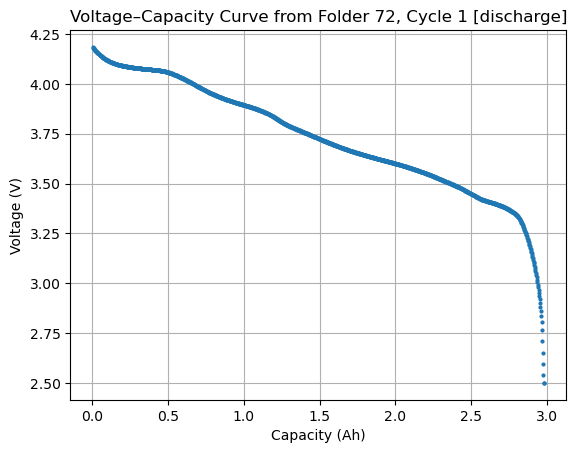

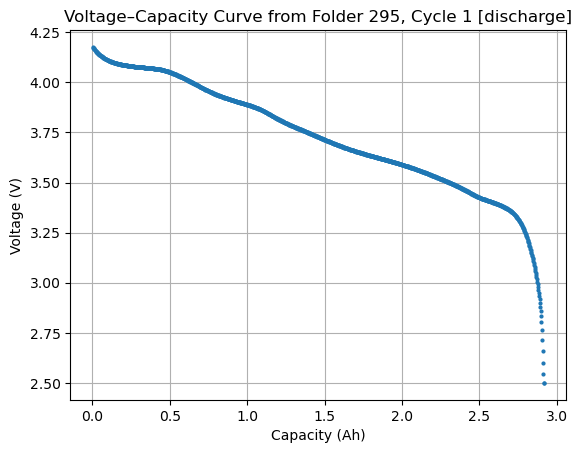

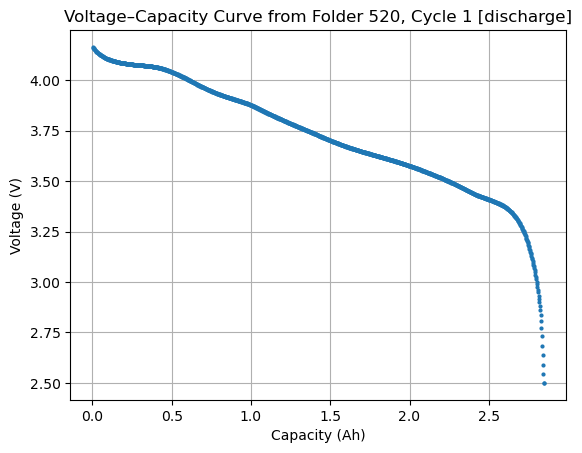

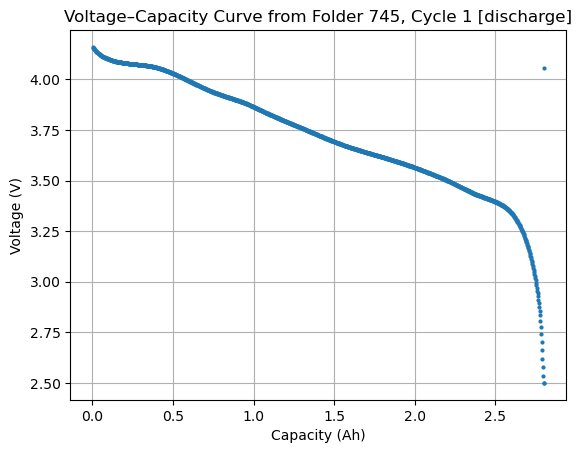

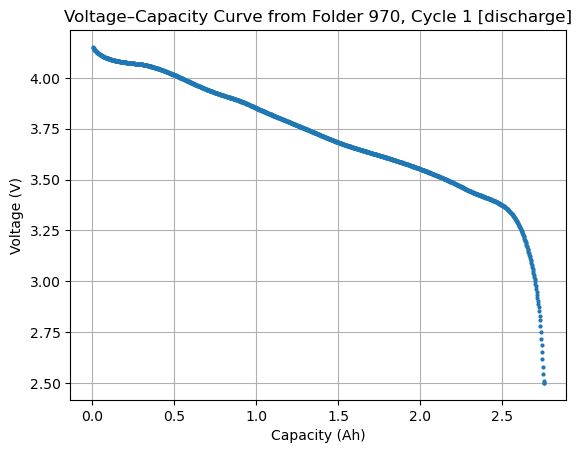

In [116]:
# Plot raw voltage vs capacity (V–Q) curves for selected cycles.
# This helps visually identify monotonic segments in Q
plot_selected_qv(folder_cycle_pairs=[
    (72, 1), (295, 1), 
    (520, 1), (745, 1), (970, 1)],
    process='discharge',
    min_seg_length = 50,
    min_v_variation = 10,
    linestyle='none',
    marker='o',
    markersize=2)

In [117]:
save_from_qrange(folder_cycle_pairs=[
    (72, 1), (295, 1), 
    (520, 1), (745, 1), (970, 1)], 
    process='discharge', 
    min_seg_length = 50, min_v_variation = 10, 
    q_min = 0.05, q_max = 2.55)

[>>] Skipping folder 72, already cached.
[>>] Skipping folder 295, already cached.
[>>] Skipping folder 520, already cached.
[>>] Skipping folder 745, already cached.
[>>] Skipping folder 970, already cached.


,Current(A),Test_Time(s),Voltage(V),Discharge_Capacity(Ah),dV/dQ(V/Ah),dQ/dV(Ah/V),Discharge_Energy(Wh),Power(W),folder_no,cycle_no
0,-0.15001,5843.9746,4.1444,0.050006,0.00000,NaN,0.20823,-0.62170,72,1
1,-0.15001,5903.9743,4.1427,0.052506,NaN,0.0000,0.21859,-0.62145,72,1
2,-0.15002,5963.9740,4.1410,0.055006,0.68766,1.5126,0.22895,-0.62123,72,1
3,-0.15002,6023.9742,4.1393,0.057507,NaN,NaN,0.23930,-0.62098,72,1
4,-0.15002,6083.9728,4.1380,0.060007,0.00000,0.0000,0.24965,-0.62078,72,1
...,...,...,...,...,...,...,...,...,...,...
4995,-0.15001,65911.2180,3.3489,2.539600,NaN,NaN,9.55980,-0.50237,970,1
4996,-0.15001,65971.2180,3.3471,2.542100,0.00000,0.0000,9.56820,-0.50210,970,1
4997,-0.15000,66031.2180,3.3450,2.544600,NaN,1.2801,9.57660,-0.50175,970,1
4998,-0.15001,66091.2190,3.3428,2.547100,0.00000,NaN,9.58490,-0.50145,970,1


In [118]:
batch_process_and_save(folder_cycle_pairs=[
    (72, 1), (295, 1), 
    (520, 1), (745, 1), 
    (970, 1)], 
    process='discharge', 
    min_seg_length = 50, min_v_variation = 10, 
    q_min = 0.05, q_max = 2.35,  
    window = 19, polyorder = 3,
)

[>>] Skipping folder 72, already cached.
[>>] Skipping folder 295, already cached.
[>>] Skipping folder 520, already cached.
[>>] Skipping folder 745, already cached.
[>>] Skipping folder 970, already cached.
Failed processing folder 72, cycle 1: local variable 'x_out_col' referenced before assignment
Failed processing folder 295, cycle 1: local variable 'x_out_col' referenced before assignment
Failed processing folder 520, cycle 1: local variable 'x_out_col' referenced before assignment
Failed processing folder 745, cycle 1: local variable 'x_out_col' referenced before assignment
Failed processing folder 970, cycle 1: local variable 'x_out_col' referenced before assignment


In [120]:
plot_all_method('charge', 'Cycle 295', save_fig=False, filename="method_comparison.png")

plot_all_method('discharge', 'Cycle 72', save_fig=False, filename="method_comparison.png")

ValueError: Cycle 295 not found.

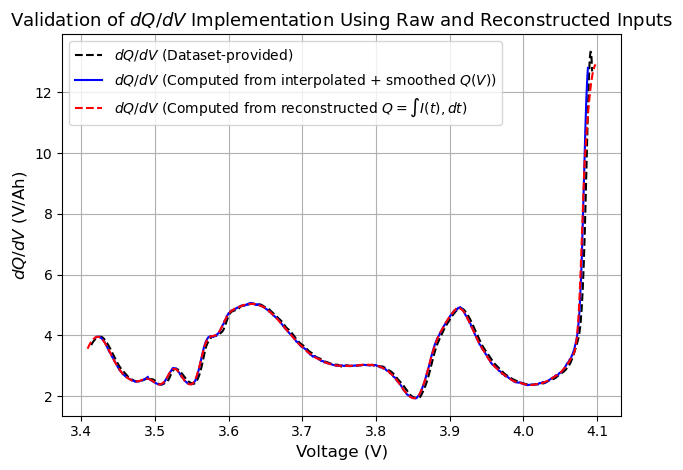

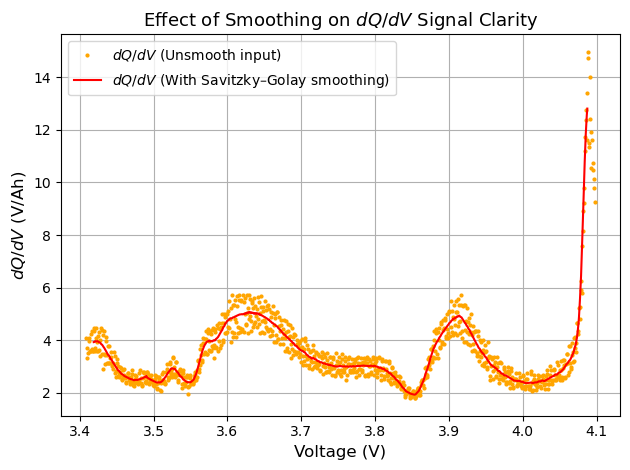

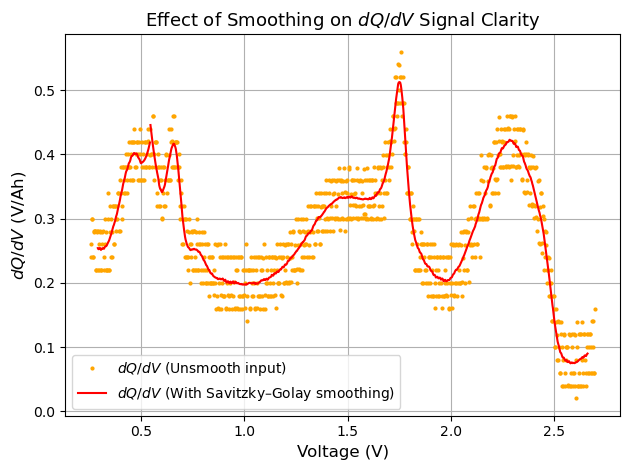

In [89]:
dqdv_validate('charge', 'Cycle 72', window = 51, polyorder = 3, save_fig=False, filename="validate_dqdv.png")
dqdv_sm_impact('charge', 'Cycle 72', save_fig=False, filename="impact_dqdv_smooth.png")
dvdq_sm_impact('charge', 'Cycle 72', save_fig=False, filename="impact_dvdq_smooth.png")

ValueError: Cycle 72 not found.

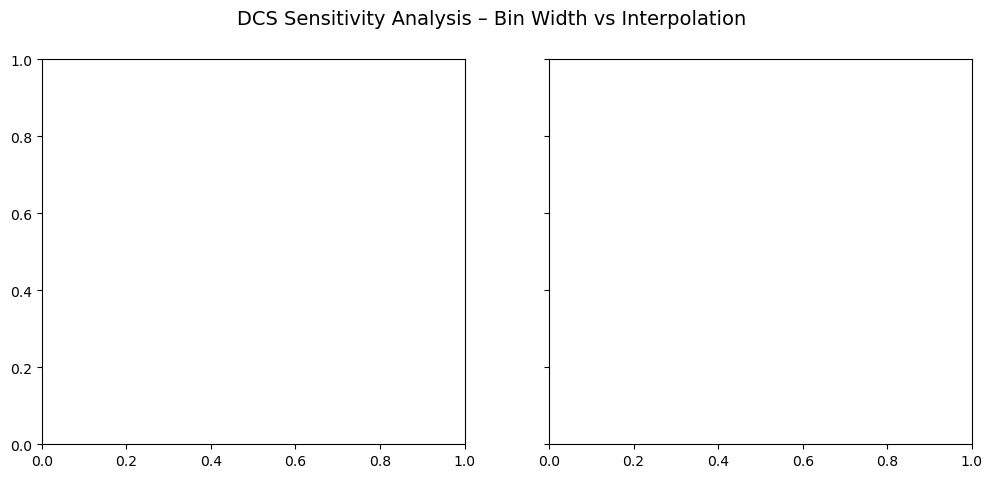

In [33]:
plot_dcs_sensitivity_comparison('charge', 'Cycle 72', save_fig=False, filename="dcs_sensitivity_pub.png")

C:\Users\Jimei\AppData\Local\Temp\ipykernel_26840\3775311024.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


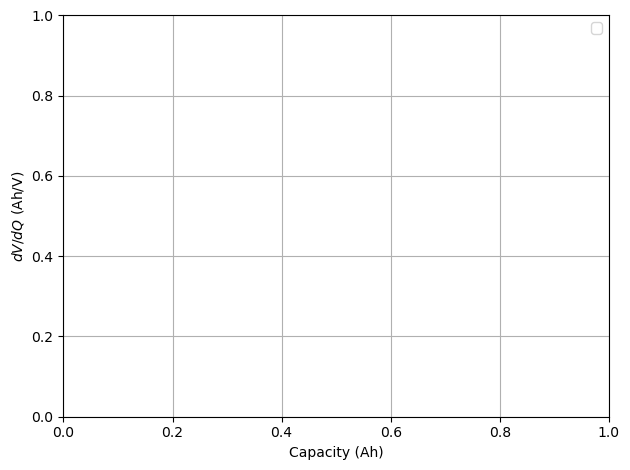

C:\Users\Jimei\AppData\Local\Temp\ipykernel_26840\3775311024.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


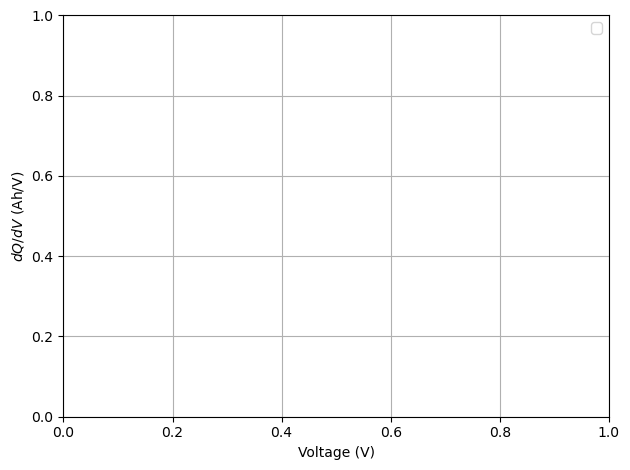

C:\Users\Jimei\AppData\Local\Temp\ipykernel_26840\3775311024.py:73: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


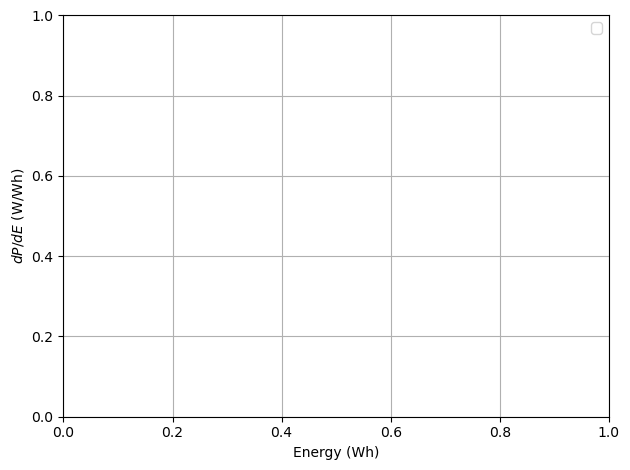

C:\Users\Jimei\AppData\Local\Temp\ipykernel_26840\3775311024.py:101: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


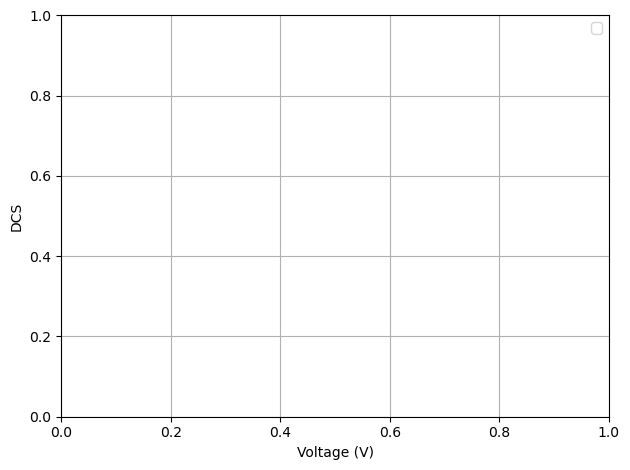

In [30]:
charge_data = select_process('charge')
discharge_data = select_process('discharge')

multi_dvdq_plot(discharge_data, save_fig=False, filename="multi_dvdq.png", linestyle='none', marker='o', markersize=1)

multi_dqdv_plot(charge_data, save_fig=False, filename="multi_dqdv.png", linestyle='-', marker='o', markersize=1)

multi_dpde_plot(charge_data, save_fig=False, filename="multi_dpde.png", linestyle='none', marker='o', markersize=1)

multi_dcs_plot(charge_data, save_fig=False, filename="multi_dcs.png", linestyle='none', marker='o', markersize=1)